### Libraries

In [1]:
import numpy as np
import pandas as pd
import warnings

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [2]:
warnings.filterwarnings("ignore")

# 한글 처리
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

# 폰트 이름 얻어오기
font_name = fm.FontProperties(fname=font_path).get_name()

# 폰트 설정
plt.rcParams['font.family'] = font_name


### Load data

In [3]:
from dotenv import load_dotenv
import os 
load_dotenv()
df_train = pd.read_csv(os.getenv('TRAIN_DATA_PATH')).drop(columns=['ID'])
df_test = pd.read_csv(os.getenv('TEST_DATA_PATH')).drop(columns=['ID'])

df_train.head(8).to_csv('train_sample.csv', encoding = 'utf-8-sig', index = False)

# df_train = pd.read_csv('data/train.csv').drop(columns=['ID'])
# df_test = pd.read_csv('data/test.csv').drop(columns=['ID'])

In [4]:
print(df_train.shape)
df_train.head(2)

(256351, 68)


,시술 시기 코드,시술 당시 나이,임신 시도 또는 마지막 임신 경과 연수,시술 유형,특정 시술 유형,배란 자극 여부,배란 유도 유형,단일 배아 이식 여부,착상 전 유전 검사 사용 여부,착상 전 유전 진단 사용 여부,...,기증 배아 사용 여부,대리모 여부,PGD 시술 여부,PGS 시술 여부,난자 채취 경과일,난자 해동 경과일,난자 혼합 경과일,배아 이식 경과일,배아 해동 경과일,임신 성공 여부
0,TRZKPL,만18-34세,NaN,IVF,ICSI,1,기록되지 않은 시행,0.0,NaN,0.0,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,3.0,NaN,0
1,TRYBLT,만45-50세,NaN,IVF,ICSI,0,알 수 없음,0.0,NaN,0.0,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0


In [5]:
print(df_test.shape)
df_test.head(2)

(90067, 67)


,시술 시기 코드,시술 당시 나이,임신 시도 또는 마지막 임신 경과 연수,시술 유형,특정 시술 유형,배란 자극 여부,배란 유도 유형,단일 배아 이식 여부,착상 전 유전 검사 사용 여부,착상 전 유전 진단 사용 여부,...,신선 배아 사용 여부,기증 배아 사용 여부,대리모 여부,PGD 시술 여부,PGS 시술 여부,난자 채취 경과일,난자 해동 경과일,난자 혼합 경과일,배아 이식 경과일,배아 해동 경과일
0,TRYBLT,만35-37세,NaN,IVF,IVF,1,기록되지 않은 시행,0.0,NaN,0.0,...,1.0,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN
1,TRDQAZ,만18-34세,NaN,IVF,IVF,1,기록되지 않은 시행,0.0,NaN,0.0,...,1.0,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN


### Preprocessing

#### 컬럼 제거

In [6]:
# 결측 비율 80% 이상 제거
missing_ratio = df_train.isnull().mean()
column_missing = missing_ratio[missing_ratio >= 0.8].index.tolist()

# nunique = 1 제거 
unique_counts = df_train.nunique()
column_nunique = unique_counts[unique_counts == 1].index.tolist()

# 컬럼 제거
dropped_columns = list(set(column_missing + column_nunique + ['배란 유도 유형']))

df_train = df_train.drop(columns=dropped_columns)
df_test = df_test.drop(columns=dropped_columns)

print("제거된 컬럼 개수:", len(dropped_columns))
print("제거된 컬럼:", dropped_columns)
print("df_train.shape:", df_train.shape)
print("df_test.shape:", df_test.shape)

제거된 컬럼 개수: 9
제거된 컬럼: ['PGS 시술 여부', '임신 시도 또는 마지막 임신 경과 연수', '난자 해동 경과일', '불임 원인 - 여성 요인', '배란 유도 유형', '착상 전 유전 검사 사용 여부', 'PGD 시술 여부', '난자 채취 경과일', '배아 해동 경과일']
df_train.shape: (256351, 59)
df_test.shape: (90067, 58)


#### 29-38. astype(int)

In [7]:
# '횟수'를 포함하는 컬럼 찾기
count_columns = [col for col in df_train.columns if '횟수' in col]

def extract_number(value):
    if isinstance(value, str):
        return int(value[0])  # 맨 앞자리 숫자로 변환
    return value

for col in count_columns:
    df_train[col] = df_train[col].apply(extract_number).astype(int)
    df_test[col] = df_test[col].apply(extract_number).astype(int)
print("변환된 컬럼:", count_columns)

변환된 컬럼: ['총 시술 횟수', '클리닉 내 총 시술 횟수', 'IVF 시술 횟수', 'DI 시술 횟수', '총 임신 횟수', 'IVF 임신 횟수', 'DI 임신 횟수', '총 출산 횟수', 'IVF 출산 횟수', 'DI 출산 횟수']


#### 29,31,32. 총 시술 횟수 재정의

In [8]:
# 총 시술 횟수 재정의
def update_total_counts(df):
    df['총 시술 횟수'] = df['IVF 시술 횟수'] + df['DI 시술 횟수']
    df['총 임신 횟수'] = df['IVF 임신 횟수'] + df['DI 임신 횟수']
    df['총 출산 횟수'] = df['IVF 출산 횟수'] + df['DI 출산 횟수']
    return df

df_train = update_total_counts(df_train)
df_test = update_total_counts(df_test)

#### 2. 55-56. 나이

In [9]:
# # 중앙값으로 나이 변환
# def mapping_age(df, column, age):
#     df[column] = df[column].map(age)
#     return df

# patient_age = {
#     '만18-34세': 26,  
#     '만35-37세': 36,  
#     '만38-39세': 38.5,  
#     '만40-42세': 41,  
#     '만43-44세': 43.5,  
#     '만45-50세': 47.5,  
# #     '알 수 없음': (38.5 + 41) / 2  # value_counts = 329 / 999 or 0 or np.nan or 중앙값으로 대체
#     '알 수 없음': 999
# }

# egg_age = {
#     '만20세 이하': 18,  
#     '만21-25세': 23,  
#     '만26-30세': 28,  
#     '만31-35세': 33,  
# #     '알 수 없음': (23 + 28) / 2
#     '알 수 없음': 999
# }

# sperm_age = {
#     '만20세 이하': 18,  
#     '만21-25세': 23,  
#     '만26-30세': 28,  
#     '만31-35세': 33,  
#     '만36-40세': 38,  
#     '만41-45세': 43,  
# #     '알 수 없음': (28 + 33) / 2
#     '알 수 없음': 999
# }

# df_train = mapping_age(df_train, '시술 당시 나이', patient_age)
# df_test = mapping_age(df_test, '시술 당시 나이', patient_age)
# df_train = mapping_age(df_train, '난자 기증자 나이', egg_age)
# df_test = mapping_age(df_test, '난자 기증자 나이', egg_age)
# df_train = mapping_age(df_train, '정자 기증자 나이', sperm_age)
# df_test = mapping_age(df_test, '정자 기증자 나이', sperm_age)

#### 5. 특정 시술 유형 > One-hot encoding / 추가 시술 여부 컬럼 생성

In [10]:
# def add_trt(df):
#     types = ['IVF', 'ICSI', 'IUI', 'ICI', 'GIFT', 'FER', 'Generic DI', 'IVI', 'BLASTOCYST', 'AH', 'Unknown']
#     df['추가 시술 여부'] = df['특정 시술 유형'].apply(lambda x: 1 if sum(t in str(x) for t in types) >= 2 else 0)
    
#     return df

# df_train = add_trt(df_train)
# df_test = add_trt(df_test)

In [11]:
def ICSI_check(df):
    df['특정 시술 유형 - ICSI'] = np.where(df['시술 유형'] != 'IVF', -1,  # 시술 유형이 DI
                             np.where(df['특정 시술 유형'].str.contains('ICSI', na=False), 2, 1))

    df = df.drop(columns=['특정 시술 유형'])
    
    return df

df_train = ICSI_check(df_train)
df_test = ICSI_check(df_test)

In [12]:
# df_train = df_train.drop(columns=['특정 시술 유형'])
# df_test = df_test.drop(columns=['특정 시술 유형'])

#### 28. 배아 생성 주요 이유: 기증용, 난자 저장용, 배아 저장용, 연구용, 현재 시술용

In [13]:
def get_dummies(df):
#     df['배아 생성 주요 이유 - 현재 시술용'] = np.where(df['시술 유형'] != 'IVF', -1, 
#                              np.where(df['배아 생성 주요 이유'].str.contains('현재 시술용', na=False), 2, 1))
    
    df = df.drop(columns=['배아 생성 주요 이유'])
    
    return df

df_train = get_dummies(df_train)
df_test = get_dummies(df_test)

In [14]:
# import pandas as pd

# def remove_invalid_rows(df):
#     # "이식된 배아수"가 0이고, "임신성공여부"가 1인 행 제거
#     df = df[~((df['이식된 배아 수'] == 0) & (df['임신 성공 여부'] == 1))]

#     return df

# # 변환 적용
# df_train = remove_invalid_rows(df_train)



#### 남성/여성/부부 주/부 불임 원인 제거

In [15]:
# # 남성, 여성, 부부의 불임 원인 통합 (주, 부)
# def infertility_cause(df):
#     df['남성 불임 원인'] = ((df['남성 주 불임 원인'] == 1) | (df['남성 부 불임 원인'] == 1)).astype(int)
#     df['여성 불임 원인'] = ((df['여성 주 불임 원인'] == 1) | (df['여성 부 불임 원인'] == 1)).astype(int)
#     df['부부 불임 원인'] = ((df['부부 주 불임 원인'] == 1) | (df['부부 부 불임 원인'] == 1)).astype(int)
    
#     drop_cols = ['남성 주 불임 원인', '남성 부 불임 원인',
#                  '여성 주 불임 원인', '여성 부 불임 원인',
#                  '부부 주 불임 원인', '부부 부 불임 원인']
    
#     df = df.drop(columns=drop_cols, errors='ignore')

#     return df

# df_train = infertility_cause(df_train)
# df_test = infertility_cause(df_test)

In [16]:
# def drop_cols(df):
# #     cols = ['불임 원인 - 난관 질환', '불임 원인 - 남성 요인', 
# #             '불임 원인 - 배란 장애', '불임 원인 - 자궁경부 문제',
# #             '불임 원인 - 자궁내막증', '불임 원인 - 정자 농도', 
# #             '불임 원인 - 정자 면역학적 요인', '불임 원인 - 정자 운동성', 
# #             '불임 원인 - 정자 형태' ]
#     cols = ['불임 원인 - 자궁경부 문제', '불임 원인 - 정자 면역학적 요인']
    
#     df = df.drop(columns=cols, errors='ignore')

#     return df

# df_train = drop_cols(df_train)
# df_test = drop_cols(df_test)

In [17]:
def drop_cols(df):
    cols = ['남성 주 불임 원인', '남성 부 불임 원인', 
            '여성 주 불임 원인', '여성 부 불임 원인',
            '부부 주 불임 원인', '부부 부 불임 원인']
    
    df = df.drop(columns=cols, errors='ignore')

    return df

df_train = drop_cols(df_train)
df_test = drop_cols(df_test)

In [18]:
def advanced_features(df):
    epsilon = 1e-5  # 분모 0 방지를 위한 작은 값


#  바이너리(Yes/No) 변수 조합: 
    # 배란 자극, 단일 배아 이식, 착상 전 유전 진단, 동결/신선/기증 배아 사용, 대리모 여부
    binary_cols = [
        '배란 자극 여부', '단일 배아 이식 여부', '착상 전 유전 진단 사용 여부',
        '동결 배아 사용 여부', '신선 배아 사용 여부', '기증 배아 사용 여부', '대리모 여부'
    ]
    # 이미 0/1로 변환되어 있다고 가정하고, 총 개수 합산
    df['바이너리_합'] = df[binary_cols].sum(axis=1)
    # 예시로 특정 두 변수 간 상호작용 (배란 자극과 단일 배아 이식)
    df['배란자극x단일이식'] = df['배란 자극 여부'] * df['단일 배아 이식 여부']
    
    # 6. 경과일 차이: 배아 이식 경과일과 난자 혼합 경과일의 차이
    df['경과일_차이'] = df['배아 이식 경과일'] - df['난자 혼합 경과일']
    

#  불임 원인 관련 피처: 여러 불임 원인 컬럼을 합쳐서 총 원인 수 산출
    infertility_cols = [
        '불명확 불임 원인', '불임 원인 - 난관 질환', '불임 원인 - 남성 요인',
        '불임 원인 - 배란 장애', '불임 원인 - 자궁경부 문제', '불임 원인 - 자궁내막증',
        '불임 원인 - 정자 농도', '불임 원인 - 정자 면역학적 요인',
        '불임 원인 - 정자 운동성', '불임 원인 - 정자 형태'
    ]
    # 만약 해당 컬럼들이 문자열(Y/N)이라면 0/1로 변환
    for col in infertility_cols:
        if df[col].dtype == 'object':
            df[col] = df[col].map({'Y': 1, 'N': 0})
    df['불임원인_수'] = df[infertility_cols].sum(axis=1)
    
    #  ICSI와 배란자극 여부 상호작용: ICSI 효과가 배란자극 여부와 어떻게 연관되는지
    df['ICSIx배란자극'] = df['특정 시술 유형 - ICSI'] * df['배란 자극 여부']
    
    #  배아 저장 비율: 생성된 배아 중 얼마나 많은 배아가 저장되었는지
    df['배아저장비율'] = df['저장된 배아 수'] / (df['총 생성 배아 수'] + epsilon)
    
    return df

# 학습/테스트 데이터에 적용
df_train = advanced_features(df_train)
df_test  = advanced_features(df_test)

### Feature engineering

In [19]:
def feature_engineering_ivf(df):
    # IVF에만 적용
#     df = df[df['시술 유형'] == 'IVF']
    
    # 임신 성공률
    df['IVF 임신 성공률'] = df['IVF 임신 횟수'] / df['IVF 시술 횟수']
    # df['배아 이식 대비 임신 성공률'] = df['총 임신 횟수'] / df['이식된 배아 수']
    
    # 출산 성공률
    df['IVF 출산 성공률'] = df['IVF 출산 횟수'] / df['IVF 임신 횟수']
    # df['배아 이식 대비 출산 성공률'] = df['총 출산 횟수'] / df['이식된 배아 수']
    
    # 배아 이식
    df["이식된 배아 대비 이식 기간"] = df["배아 이식 경과일"] / df["이식된 배아 수"]
    
    # 난자
    df['총 난자 수'] = df['수집된 신선 난자 수'] + df['해동 난자 수']
    df['난자 사용률'] = df['혼합된 난자 수'] / df['총 난자 수']
    df['미세주입 X 난자 수'] = df['혼합된 난자 수'] - df['미세주입된 난자 수']
    
    # 배아
    df['총 배아 수'] = df['총 생성 배아 수'] + df['해동된 배아 수']
    df['미세주입 X 배아 수'] = df['총 생성 배아 수'] - df['미세주입에서 생성된 배아 수']
    df['미세주입 배아 생성 확률'] = df['미세주입에서 생성된 배아 수'] / df['미세주입된 난자 수']
    df['미세주입 배아 이식 확률'] = df['미세주입 배아 이식 수'] / df['미세주입에서 생성된 배아 수']
    df['미세주입 X 배아 생성 확률'] = df['미세주입 X 배아 수'] / df['미세주입 X 난자 수']
    df['총 배아 생성 확률'] = df['총 배아 수'] / df['총 난자 수']
    df['배아 이식 확률'] = df['이식된 배아 수'] / df['총 배아 수']
    df['동결&IVF 배아 이식 확률'] = (df['이식된 배아 수'] - df['미세주입 배아 이식 수']) / (df['총 배아 수'] - df['미세주입에서 생성된 배아 수'])
    # df['이식이식 배아 수'] = df['이식된 배아 수']
    # df['이식이식이식 배아 수'] = df['이식된 배아 수']
    # df['이식이식이식이식 배아 수'] = df['이식된 배아 수']
    # df['이식이식이식이식 배아배아 수'] = df['이식된 배아 수']

    # 나이
    df.loc[df['시술 유형'] == 'IVF', '나이 그룹별 평균 생성 배아 수'] = df.groupby('시술 당시 나이')['총 배아 수'].transform('mean')
    df.loc[df['시술 유형'] == 'IVF', '나이 그룹별 평균 이식 배아 수'] = df.groupby('시술 당시 나이')['이식된 배아 수'].transform('mean')
    df.loc[df['시술 유형'] == 'IVF', '나이 그룹별 평균 배아 이식 확률'] = df.groupby('시술 당시 나이')['배아 이식 확률'].transform('mean')
    df.loc[df['시술 유형'] == 'IVF', '나이 그룹별 평균 배아 생성 확률'] = df.groupby('시술 당시 나이')['총 배아 생성 확률'].transform('mean')
    df.loc[df['시술 유형'] == 'IVF', '나이 그룹별 평균 배아 이식 경과일'] = df.groupby('시술 당시 나이')['배아 이식 경과일'].transform('mean')
    
#     df['나이 그룹별 평균 시술 확률'] = df.groupby('시술 당시 나이')['총 시술 횟수'].transform('mean')
#     df['나이 그룹별 평균 임신 확률'] = df.groupby('시술 당시 나이')['총 임신 횟수'].transform('mean')
#     df['나이 그룹별 평균 출산 확률'] = df.groupby('시술 당시 나이')['총 출산 횟수'].transform('mean')
    
    cols = ['총 난자 수','미세주입 X 난자 수','미세주입 X 배아 수','미세주입 X 배아 생성 확률','동결&IVF 배아 이식 확률']
    df = df.drop(columns=cols, errors='ignore')
    
    return df

df_train = feature_engineering_ivf(df_train)
df_test = feature_engineering_ivf(df_test)

In [20]:
def di_null(df):
    df.loc[df['시술 유형'] == 'DI'] = df.loc[df['시술 유형'] == 'DI'].fillna(-1)
    return df

df_train = di_null(df_train)
df_test = di_null(df_test)

In [21]:
# 결측 비율
missing_ratio = df_train.isnull().mean() * 100
print(missing_ratio)

시술 시기 코드                0.000000
시술 당시 나이                0.000000
시술 유형                   0.000000
배란 자극 여부                0.000000
단일 배아 이식 여부             0.000000
                         ...    
나이 그룹별 평균 생성 배아 수       0.000000
나이 그룹별 평균 이식 배아 수       0.000000
나이 그룹별 평균 배아 이식 확률     90.204836
나이 그룹별 평균 배아 생성 확률     97.545943
나이 그룹별 평균 배아 이식 경과일     0.128340
Length: 72, dtype: float64


In [22]:
# 결측값 대체
def replace_inf_and_nan(df, value):
    df.replace([np.inf, -np.inf], value, inplace=True)  # inf, -inf를 999로 변환
    df.fillna(value, inplace=True)  # NaN도 999로 변환
    return df

# 변환 적용
value = 999
df_train = replace_inf_and_nan(df_train, value)
df_test = replace_inf_and_nan(df_test, value)

### Feature selection

In [23]:
# # 범주형 변수 확인
# binary_features = [
#     "배란 자극 여부", "단일 배아 이식 여부", "착상 전 유전 진단 사용 여부",
#     "불명확 불임 원인", "불임 원인 - 난관 질환", "불임 원인 - 남성 요인",
#     "불임 원인 - 배란 장애", "불임 원인 - 자궁내막증", "불임 원인 - 정자 농도",
#     "불임 원인 - 정자 운동성", "불임 원인 - 정자 형태", "동결 배아 사용 여부",
#     "신선 배아 사용 여부", "기증 배아 사용 여부", "대리모 여부",
#     "특정 시술 유형 - ICSI", "배아 생성 주요 이유 - 현재 시술용"
# ]

# df_train[binary_features] = df_train[binary_features].fillna(2).astype(int)
# df_test[binary_features] = df_test[binary_features].fillna(2).astype(int)

# cat_features = list(set(df_train.select_dtypes(include=['object']).columns) | set(binary_features))
# # cat_features = list(df_train.select_dtypes(include=['object']).columns)

# cat_features

In [24]:
# object 타입 컬럼 확인
cat_features = list(df_train.select_dtypes(include=['object']).columns)
cat_features

['시술 시기 코드', '시술 당시 나이', '시술 유형', '난자 출처', '정자 출처', '난자 기증자 나이', '정자 기증자 나이']

In [25]:
# object 타입 컬럼 확인
cat_features = list(df_train.select_dtypes(include=['object']).columns)
cat_features

# LabelEncoder 적용
for col in cat_features:
    le = LabelEncoder() 
    df_train[col] = le.fit_transform(df_train[col])  
    df_test[col] = le.transform(df_test[col]) 

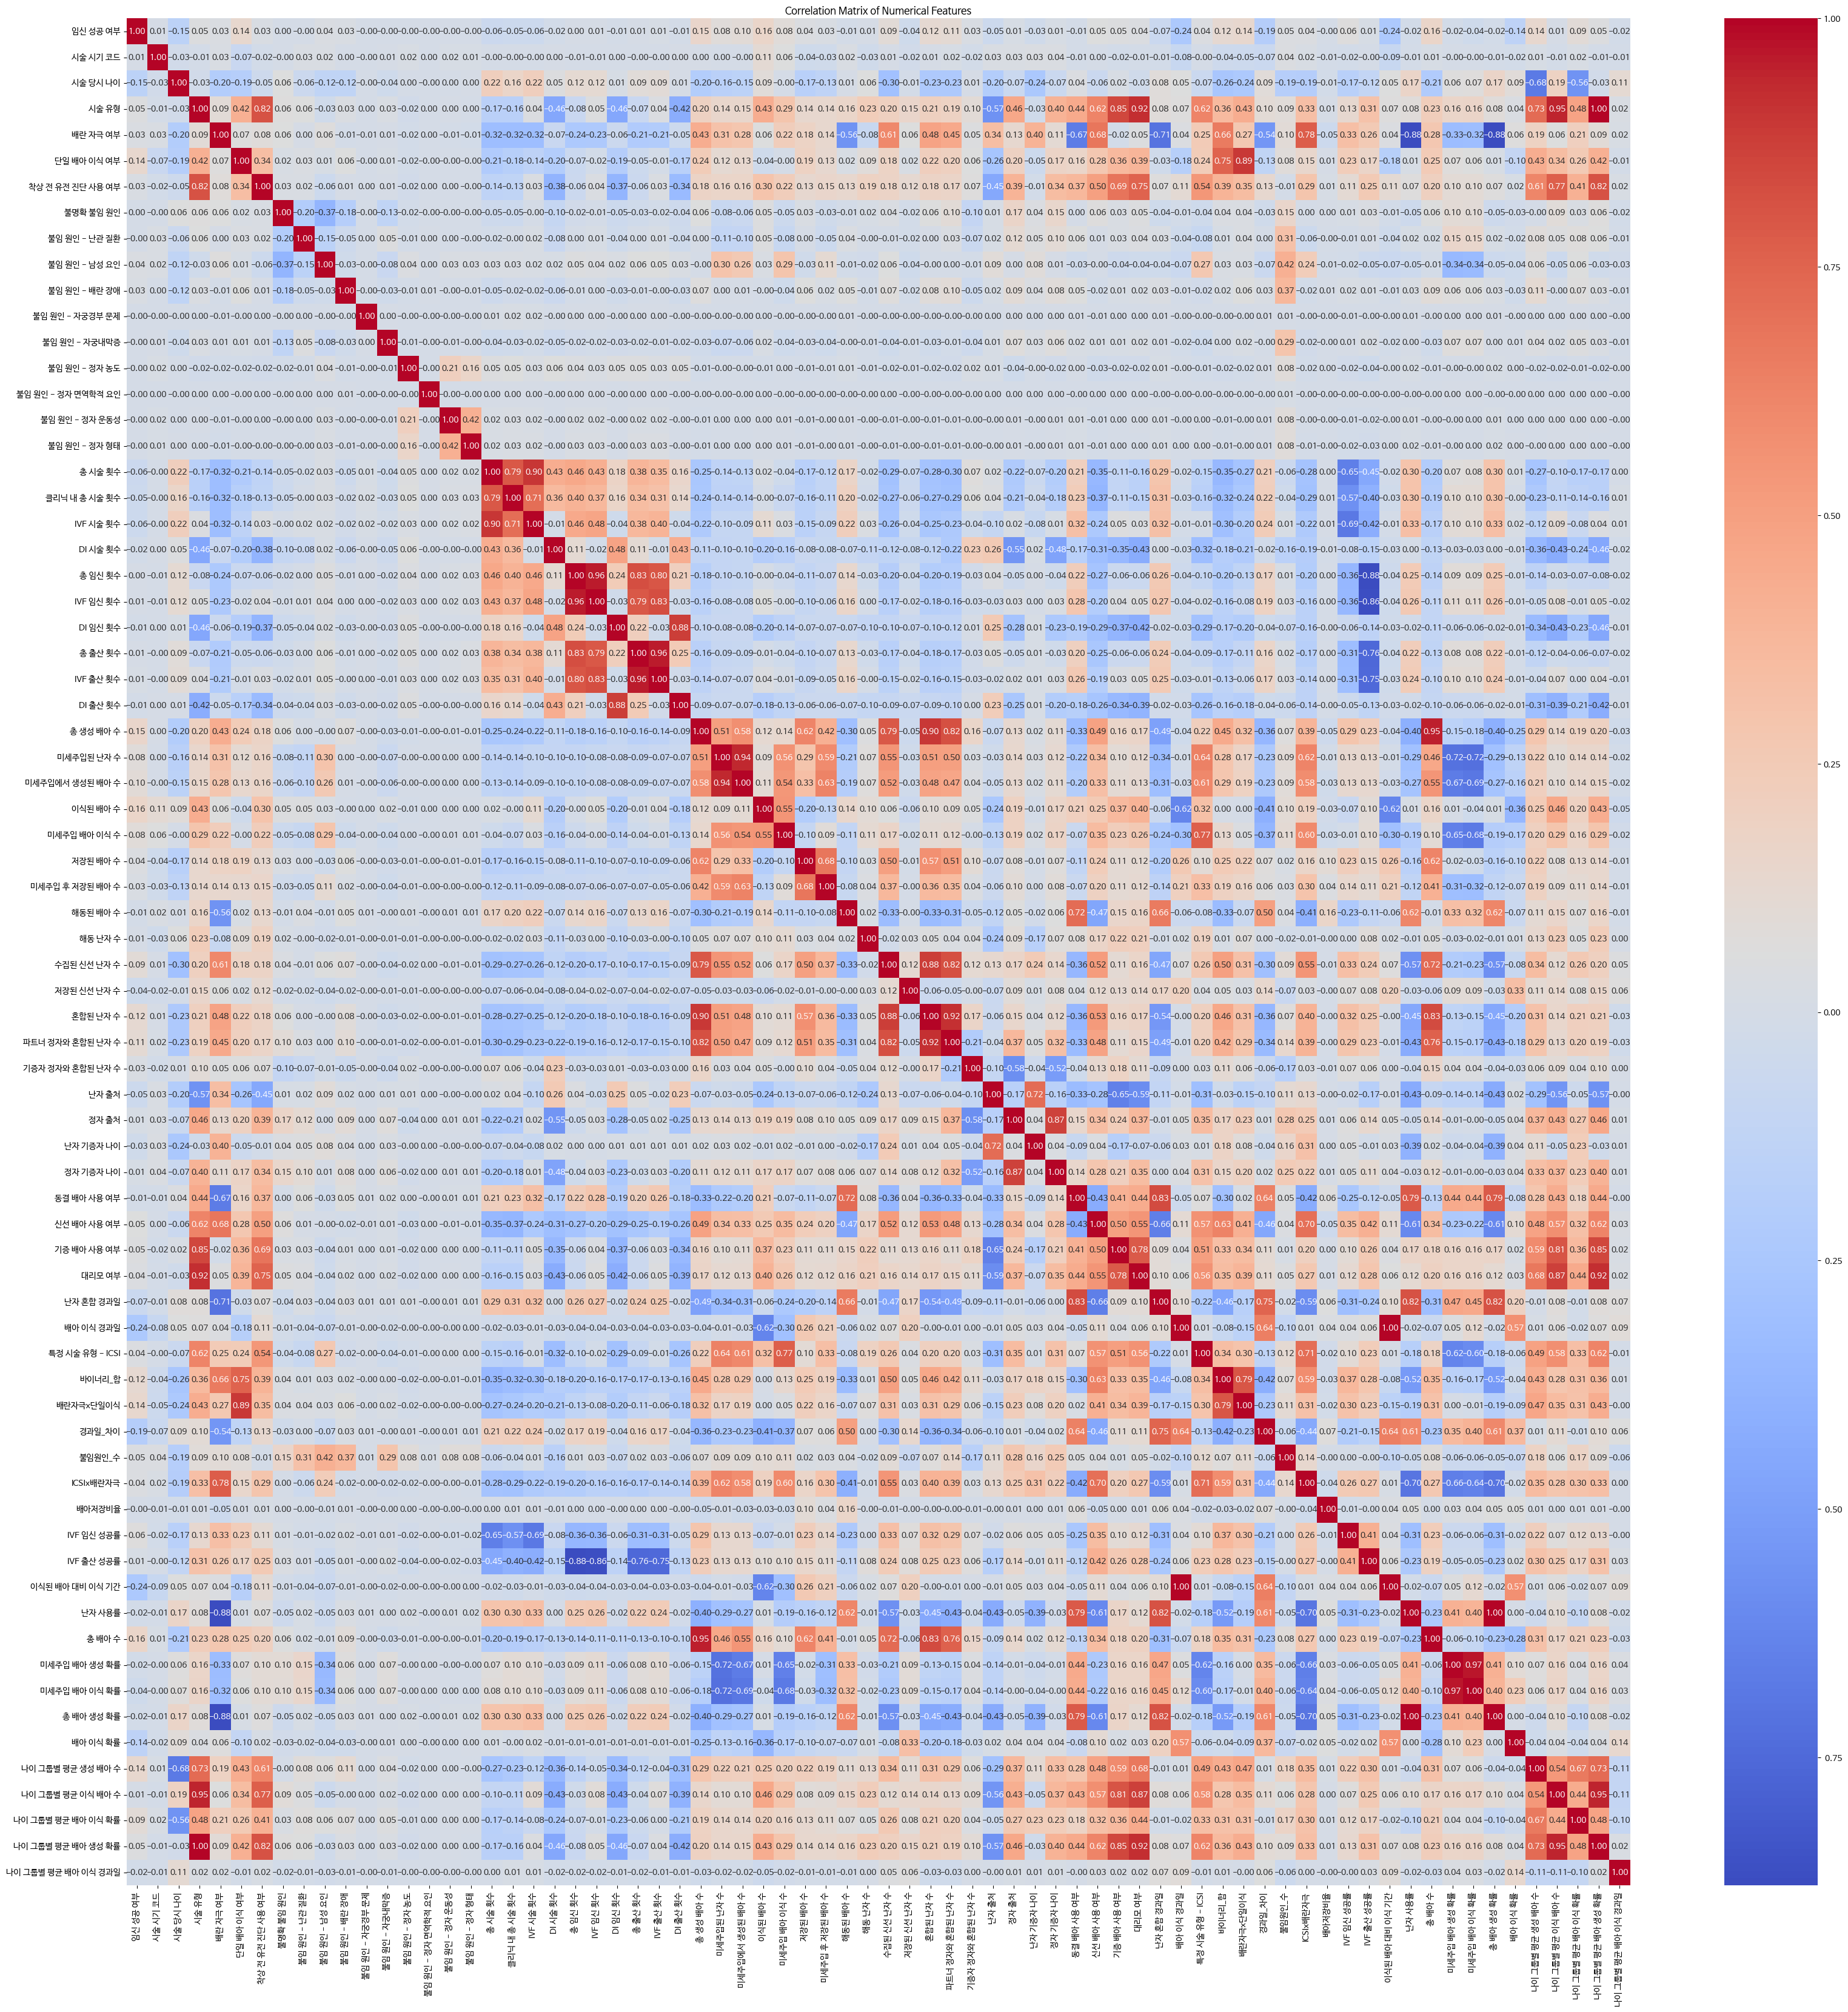

In [26]:
from utils.EDA import vis_numeric_corr_matrix

vis_numeric_corr_matrix(df_train)

### Modeling

In [27]:
X = df_train.drop('임신 성공 여부', axis=1)
y = df_train['임신 성공 여부']
X_test = df_test

In [28]:
df_train['임신 성공 여부'].value_counts()

임신 성공 여부
0    190123
1     66228
Name: count, dtype: int64

### Scaling

In [29]:

scaling_cols = [
    '총 생성 배아 수',
    '미세주입된 난자 수',
    '미세주입에서 생성된 배아 수',
    '이식된 배아 수', 
    '미세주입 배아 이식 수',
    '저장된 배아 수',
    '미세주입 후 저장된 배아 수',
    '해동된 배아 수',
    '해동 난자 수',
    '수집된 신선 난자 수',
    '저장된 신선 난자 수',
    '혼합된 난자 수',
    '파트너 정자와 혼합된 난자 수',
    '기증자 정자와 혼합된 난자 수',
    '난자 혼합 경과일',
    '배아 이식 경과일',
    '경과일_차이',
    '불임원인_수',
    '배아저장비율',
    '이식된 배아 대비 이식 기간',
    '총 배아 수',
    '나이 그룹별 평균 생성 배아 수',
    '나이 그룹별 평균 이식 배아 수',
    '나이 그룹별 평균 배아 이식 경과일',
]

In [30]:
# # Standard Scaling
# scaler = MinMaxScaler()
# X[scaling_cols] = scaler.fit_transform(X[scaling_cols])
# X_test[scaling_cols] = scaler.transform(X_test[scaling_cols])

scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns, index=X.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

### Correlation

#### Stratified K-Fold 

In [31]:
# Stratified K-Fold 설정
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)

metrics = {model: [] for model in ['CatBoost']} # Ensemble
feature_importances = {model: [] for model in ['CatBoost']}
test_proba = {model: [] for model in ['CatBoost']} # Ensemble

# metrics = {model: [] for model in ['CatBoost', 'XGBoost', 'LightGBM', 'AdaBoost']} # Ensemble
# feature_importances = {model: [] for model in ['CatBoost', 'XGBoost', 'LightGBM', 'AdaBoost']}
# test_proba = {model: [] for model in ['CatBoost', 'XGBoost', 'LightGBM', 'AdaBoost']} # Ensemble

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"===== Fold {fold} =====")

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # 모델 정의
    cat_model = CatBoostClassifier(
        iterations=700, learning_rate=0.03, depth=8, l2_leaf_reg=10,
        subsample=0.8, colsample_bylevel=0.8, random_strength=10, 
#         cat_features=cat_features, # 속도 너무 느려
        loss_function='Logloss', eval_metric='AUC', verbose=100, random_seed=123
    )

    xgb_model = XGBClassifier(
        n_estimators=700, learning_rate=0.03, max_depth=7, min_child_weight=3,
        gamma=0.1, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1,
        reg_lambda=1.0, verbosity=1, random_state=123
    )

    lgbm_model = LGBMClassifier(
        n_estimators=700, learning_rate=0.03, max_depth=-1, num_leaves=64,
        min_child_samples=20, subsample=0.8, colsample_bytree=0.8,
        reg_alpha=0.1, reg_lambda=1.0, verbosity=1, random_state=123
    )
    
    adaboost_model = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=2, min_samples_split=10, min_samples_leaf=5, random_state=123),
        n_estimators=500, learning_rate=0.05,
        algorithm="SAMME", random_state=123
    )
    
#     ensemble_model = VotingClassifier(
#         estimators=[('catboost', cat_model), ('xgboost', xgb_model), ('lightgbm', lgbm_model), ('adaboost', adaboost_model)],
#         voting='soft', weights=[1, 1, 1, 0.8]
#     )


    # 모델 학습
    for model in [cat_model]: # ensemble_model
#     for model in [cat_model, xgb_model, lgbm_model, adaboost_model]: # ensemble_model
        model.fit(X_train, y_train)

    # 평가 함수
    def evaluate_model(model, X_val, y_true):
        y_pred = model.predict(X_val)
        y_pred_proba = model.predict_proba(X_val)[:, 1]

        return {
            'Accuracy': accuracy_score(y_true, y_pred),
            'Precision': precision_score(y_true, y_pred),
            'Recall': recall_score(y_true, y_pred),
            'F1 Score': f1_score(y_true, y_pred),
            'ROC AUC Score': roc_auc_score(y_true, y_pred_proba)
        }

    # 평가 및 변수 중요도 저장
    for model_name, model in zip(metrics.keys(), [cat_model]): # ensemble_model
        metrics[model_name].append(evaluate_model(model, X_val, y_val))

    for model_name, model in zip(['CatBoost'], [cat_model]):
        feature_importances[model_name].append(model.feature_importances_)
        
    # 테스트 데이터 예측 확률 저장
    test_proba['CatBoost'].append(cat_model.predict_proba(X_test)[:, 1])
#     test_proba['XGBoost'].append(xgb_model.predict_proba(X_test)[:, 1])
#     test_proba['LightGBM'].append(lgbm_model.predict_proba(X_test)[:, 1])
#     test_proba['AdaBoost'].append(adaboost_model.predict_proba(X_test)[:, 1])
#     test_proba['Ensemble'].append(ensemble_model.predict_proba(X_test)[:, 1])

===== Fold 1 =====
0:	total: 71.9ms	remaining: 50.2s


100:	total: 1.18s	remaining: 6.97s
200:	total: 2.27s	remaining: 5.63s
300:	total: 3.37s	remaining: 4.47s
400:	total: 4.47s	remaining: 3.34s
500:	total: 5.68s	remaining: 2.25s
600:	total: 6.88s	remaining: 1.13s
699:	total: 8.06s	remaining: 0us
===== Fold 2 =====
0:	total: 11.3ms	remaining: 7.87s
100:	total: 1.13s	remaining: 6.72s
200:	total: 2.21s	remaining: 5.48s
300:	total: 3.31s	remaining: 4.39s
400:	total: 4.45s	remaining: 3.32s
500:	total: 5.65s	remaining: 2.24s
600:	total: 6.87s	remaining: 1.13s
699:	total: 8.06s	remaining: 0us
===== Fold 3 =====
0:	total: 11.2ms	remaining: 7.82s
100:	total: 1.16s	remaining: 6.85s
200:	total: 2.28s	remaining: 5.67s
300:	total: 3.32s	remaining: 4.41s
400:	total: 4.45s	remaining: 3.32s
500:	total: 5.64s	remaining: 2.24s
600:	total: 6.85s	remaining: 1.13s
699:	total: 8.05s	remaining: 0us
===== Fold 4 =====
0:	total: 12.3ms	remaining: 8.57s
100:	total: 1.11s	remaining: 6.61s
200:	total: 2.28s	remaining: 5.67s
300:	total: 3.4s	remaining: 4.51s
400:	tot

In [32]:
# 평가 지표 평균 출력
print("===== Stratified K-Fold 평균 성능 =====")
for model_name, model_metrics in metrics.items():
    avg_metrics = {metric: np.mean([fold_metric[metric] for fold_metric in model_metrics]) for metric in model_metrics[0]}
    
    print(f"\n== {model_name} Model ==")
    for metric, value in avg_metrics.items():
        print(f"{metric}: {value:.6f}")

===== Stratified K-Fold 평균 성능 =====

== CatBoost Model ==
Accuracy: 0.745946
Precision: 0.539797
Recall: 0.112762
F1 Score: 0.186531
ROC AUC Score: 0.739625


In [33]:
# 최종 변수 중요도 평균 계산
df_fi_list = []
for model_name, fi_list in feature_importances.items():
    avg_importance = np.mean(fi_list, axis=0)
    df_fi = pd.DataFrame({
        'Feature': X_train.columns,
        model_name: avg_importance 
    })
    df_fi = df_fi.sort_values(by=model_name, ascending=False).reset_index(drop=True)
    df_fi_list.append(df_fi)
    
df_fi_final = pd.concat(df_fi_list, axis=1)
df_fi_final

,Feature,CatBoost
0,이식된 배아 수,29.481348
1,배아 이식 확률,12.447654
2,이식된 배아 대비 이식 기간,11.333899
3,배아 이식 경과일,7.881344
4,경과일_차이,6.104954
...,...,...
66,불임 원인 - 정자 농도,0.006076
67,불임 원인 - 정자 형태,0.002590
68,불임 원인 - 정자 운동성,0.002136
69,불임 원인 - 자궁경부 문제,0.000429


In [34]:
# catboost 기준 변수 중요도 0.1 미만 변수 제거
df_cat = df_fi_final.iloc[:, :2]
df_selected = df_cat[df_cat['CatBoost'] > 0.05]
selected_features = df_selected['Feature'].tolist()

# 중요도가 높은 피처만 선택하여 새로운 데이터 생성
X = X[selected_features]
X_test = X_test[selected_features]

### Re-modeling

In [35]:
# Stratified K-Fold 설정
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)

metrics = {model: [] for model in ['CatBoost']} # Ensemble
feature_importances = {model: [] for model in ['CatBoost']}
test_proba = {model: [] for model in ['CatBoost']} # Ensemble

# metrics = {model: [] for model in ['CatBoost', 'XGBoost', 'LightGBM', 'AdaBoost']} # Ensemble
# feature_importances = {model: [] for model in ['CatBoost', 'XGBoost', 'LightGBM', 'AdaBoost']}
# test_proba = {model: [] for model in ['CatBoost', 'XGBoost', 'LightGBM', 'AdaBoost']} # Ensemble

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"===== Fold {fold} =====")

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # 모델 정의
    cat_model = CatBoostClassifier(
        iterations=700, learning_rate=0.03, depth=8, l2_leaf_reg=10,
        subsample=0.8, colsample_bylevel=0.8, random_strength=10,
        loss_function='Logloss', eval_metric='AUC', verbose=100, random_seed=123
    )

    xgb_model = XGBClassifier(
        n_estimators=700, learning_rate=0.03, max_depth=7, min_child_weight=3,
        gamma=0.1, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1,
        reg_lambda=1.0, verbosity=1, random_state=123
    )

    lgbm_model = LGBMClassifier(
        n_estimators=700, learning_rate=0.03, max_depth=-1, num_leaves=64,
        min_child_samples=20, subsample=0.8, colsample_bytree=0.8,
        reg_alpha=0.1, reg_lambda=1.0, verbosity=1, random_state=123
    )
    
    adaboost_model = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=2, min_samples_split=10, min_samples_leaf=5, random_state=123),
        n_estimators=500, learning_rate=0.05,
        algorithm="SAMME", random_state=123
    )
    
#     ensemble_model = VotingClassifier(
#         estimators=[('catboost', cat_model), ('xgboost', xgb_model), ('lightgbm', lgbm_model), ('adaboost', adaboost_model)],
#         voting='soft', weights=[1, 1, 1, 0.8]
#     )


    # 모델 학습
    for model in [cat_model]: # ensemble_model
#     for model in [cat_model, xgb_model, lgbm_model, adaboost_model]: # ensemble_model
        model.fit(X_train, y_train)

    # 평가 함수
    def evaluate_model(model, X_val, y_true):
        y_pred = model.predict(X_val)
        y_pred_proba = model.predict_proba(X_val)[:, 1]

        return {
            'Accuracy': accuracy_score(y_true, y_pred),
            'Precision': precision_score(y_true, y_pred),
            'Recall': recall_score(y_true, y_pred),
            'F1 Score': f1_score(y_true, y_pred),
            'ROC AUC Score': roc_auc_score(y_true, y_pred_proba)
        }

    # 평가 및 변수 중요도 저장
    for model_name, model in zip(metrics.keys(), [cat_model]): # ensemble_model
        metrics[model_name].append(evaluate_model(model, X_val, y_val))

    for model_name, model in zip(['CatBoost'], [cat_model]):
        feature_importances[model_name].append(model.feature_importances_)
        
    # 테스트 데이터 예측 확률 저장
    test_proba['CatBoost'].append(cat_model.predict_proba(X_test)[:, 1])
#     test_proba['XGBoost'].append(xgb_model.predict_proba(X_test)[:, 1])
#     test_proba['LightGBM'].append(lgbm_model.predict_proba(X_test)[:, 1])
#     test_proba['AdaBoost'].append(adaboost_model.predict_proba(X_test)[:, 1])
#     test_proba['Ensemble'].append(ensemble_model.predict_proba(X_test)[:, 1])

===== Fold 1 =====
0:	total: 12.5ms	remaining: 8.72s
100:	total: 1.08s	remaining: 6.43s
200:	total: 2.18s	remaining: 5.42s
300:	total: 3.24s	remaining: 4.29s
400:	total: 4.29s	remaining: 3.2s
500:	total: 5.42s	remaining: 2.15s
600:	total: 6.58s	remaining: 1.08s
699:	total: 7.73s	remaining: 0us
===== Fold 2 =====
0:	total: 9.99ms	remaining: 6.99s
100:	total: 1.07s	remaining: 6.37s
200:	total: 2.11s	remaining: 5.25s
300:	total: 3.18s	remaining: 4.21s
400:	total: 4.19s	remaining: 3.12s
500:	total: 5.29s	remaining: 2.1s
600:	total: 6.46s	remaining: 1.06s
699:	total: 7.63s	remaining: 0us
===== Fold 3 =====
0:	total: 11.1ms	remaining: 7.74s
100:	total: 1.07s	remaining: 6.36s
200:	total: 2.12s	remaining: 5.27s
300:	total: 3.19s	remaining: 4.23s
400:	total: 4.24s	remaining: 3.16s
500:	total: 5.38s	remaining: 2.14s
600:	total: 6.54s	remaining: 1.08s
699:	total: 7.68s	remaining: 0us
===== Fold 4 =====
0:	total: 10ms	remaining: 7s
100:	total: 1.09s	remaining: 6.45s
200:	total: 2.13s	remaining: 5.

In [ ]:
# 평가 지표 평균 출력
print("===== Stratified K-Fold 평균 성능 =====")
for model_name, model_metrics in metrics.items():
    avg_metrics = {metric: np.mean([fold_metric[metric] for fold_metric in model_metrics]) for metric in model_metrics[0]}
    
    print(f"\n== {model_name} Model ==")
    for metric, value in avg_metrics.items():
        print(f"{metric}: {value:.6f}")

### Prediction

In [ ]:
# Best AUC 기록한 모델의 pred_proba로 선택
pred_proba = np.mean(test_proba['CatBoost'], axis=0)
# pred_proba = np.mean(test_proba['XGBoost'], axis=0)
# pred_proba = np.mean(test_proba['LightGBM'], axis=0)
# pred_proba = np.mean(test_proba['AdaBoost'], axis=0)
# pred_proba = np.mean(test_proba['Ensemble'], axis=0)

### Submission

In [ ]:
# sample_submission = pd.read_csv('data/sample_submission.csv')
# sample_submission.head()

sample_submission = pd.read_csv(os.getenv('SUBMISSION_DATA_PATH'))
sample_submission.head()

In [ ]:
# sample_submission['probability'] = pred_proba
# # 저장
# sample_submission.to_csv('data/submission.csv', index=False)
# sample_submission.head()

sample_submission['probability'] = pred_proba
# 저장
import datetime 
now = datetime.datetime.now()
save_path = os.path.join(f'./log/submission/{now.strftime("%Y%m%d_%H%M%S")}_eiden.csv')
sample_submission.to_csv(save_path, index=False)
sample_submission.head()

In [ ]:
# 확인용
submission = pd.read_csv(save_path)
submission.head()